**This is a preliminary ML script to determine the best models for our project data.**

In [36]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

**Import 2017 sample of 25,000 observations.**  Note import warning:"Columns (29,30,39,40) have mixed types. Specify dtype option on import or set low_memory=False."

In [37]:
# Fetch the data if required
filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample.csv"))
DATA = pd.read_csv(filepath, low_memory=False)
DATA.describe(include='all')

,Unnamed: 0,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
count,25000.000000,25000.000000,848.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.00000,21758.000000,...,25000,2,5,11,145,25000,25000,25000,25000,25000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,1,3,4,5,7,4,6,6,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Male,White,White,White,White,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Loan originated
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14027,2,2,5,111,16162,16986,12276,12276,12754
mean,12499.500000,111.397555,2.502830,5713.388400,31.196988,1453.986800,1983.270800,236.43560,70736.62400,105.568435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,7217.022701,40.126879,1.468485,3294.295145,26.444629,890.954715,1096.396276,826.32896,13831.63976,142.214077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,1.00000,15800.00000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,6249.750000,85.459999,1.670000,3824.000000,10.090000,919.000000,1340.750000,107.00000,62100.00000,50.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,12499.500000,106.370003,1.940000,5124.500000,22.080000,1320.000000,1813.000000,180.00000,69200.00000,78.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,18749.250000,131.699997,2.515000,6766.000000,46.299999,1791.000000,2387.000000,281.00000,75700.00000,120.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Drop features which are redundant or have mostly missing data + Drop first column
ALSO: drop msamd_name and census_tract_number, as they make each bin of data too granular**

In [3]:
DATA = DATA.drop(DATA.columns[0], axis=1)

DATA = DATA.drop(['rate_spread', 
        'state_name', 
        'sequence_number', 
        'respondent_id',
        'msamd_name',
        'edit_status_name', 
        'denial_reason_name_3', 
        'denial_reason_name_2', 
        'denial_reason_name_1', 
        'co_applicant_race_name_5', 
        'co_applicant_race_name_4', 
        'co_applicant_race_name_3', 
        'co_applicant_race_name_2',
        'census_tract_number',
        'application_date_indicator', 
        'applicant_race_name_5', 
        'applicant_race_name_4', 
        'applicant_race_name_3', 
        'applicant_race_name_2', 
        'agency_name'], 
        axis=1)


**Write the initial script using subset of features which are already int or float, plus the target** 

**IDEAS: discard file closed, call 'application approved but not accepted" a 1 or discard, discard 'application withdrawn by applicant'.  Concern about overfitting if we leave too much stuff in.**

In [4]:
DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)
pd.crosstab(DATA['action_taken_name'],DATA['action_taken'], margins=True)

action_taken,0,1,All
action_taken_name,,,
Application approved but not accepted,700,0,700
Application denied by financial institution,3923,0,3923
Application withdrawn by applicant,2952,0,2952
File closed for incompleteness,1096,0,1096
Loan originated,0,12754,12754
Loan purchased by the institution,0,3573,3573
Preapproval request denied by financial institution,2,0,2
All,8673,16327,25000


**ACTION: look at imputing income using hud household median income rather than mean**

In [5]:
DATA_targ_numeric = DATA[['action_taken',
            'tract_to_msamd_income', 
            'population', 
            'minority_population', 
            'number_of_owner_occupied_units', 
            'number_of_1_to_4_family_units', 
            'loan_amount_000s', 
            'hud_median_family_income', 
            'applicant_income_000s' 
            ]]
#resolve missing values in applicant_income_000s
DATA_targ_numeric.fillna(DATA_targ_numeric.mean(), inplace=True)
DATA_targ_numeric.info()
DATA_basefile = DATA_targ_numeric

C:\Users\akx00\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 9 columns):
action_taken                      25000 non-null int64
tract_to_msamd_income             25000 non-null float64
population                        25000 non-null int64
minority_population               25000 non-null float64
number_of_owner_occupied_units    25000 non-null int64
number_of_1_to_4_family_units     25000 non-null int64
loan_amount_000s                  25000 non-null int64
hud_median_family_income          25000 non-null int64
applicant_income_000s             25000 non-null float64
dtypes: float64(3), int64(6)
memory usage: 1.7 MB


**Use one-hot encoding via Pandas, concatenate to the rest of the data frame.**

Reference link:
https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [6]:
DATA = DATA.drop(['action_taken_name'], axis=1)
DATA.columns

Index(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s',
       'state_abbr', 'purchaser_type_name', 'property_type_name',
       'preapproval_name', 'owner_occupancy_name', 'loan_type_name',
       'loan_purpose_name', 'lien_status_name', 'hoepa_status_name',
       'county_name', 'co_applicant_sex_name', 'co_applicant_race_name_1',
       'co_applicant_ethnicity_name', 'as_of_year', 'applicant_sex_name',
       'applicant_race_name_1', 'applicant_ethnicity_name', 'agency_abbr',
       'action_taken'],
      dtype='object')

In [38]:
non_categorical_features = ['action_taken',
                        'tract_to_msamd_income', 
                        'population', 
                        'minority_population', 
                        'number_of_owner_occupied_units', 
                        'number_of_1_to_4_family_units', 
                        'loan_amount_000s', 
                        'hud_median_family_income', 
                        'applicant_income_000s'
                       ]

In [8]:
for categorical_feature in list(DATA.columns):
    if categorical_feature not in non_categorical_features:
        DATA[categorical_feature] = DATA[categorical_feature].astype('category')
        dummies = pd.get_dummies(DATA[categorical_feature], prefix=categorical_feature)
        DATA_basefile = pd.concat([DATA_basefile, dummies], axis=1)
        
DATA_basefile.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 1255 columns):
action_taken                                                                                                     int64
tract_to_msamd_income                                                                                            float64
population                                                                                                       int64
minority_population                                                                                              float64
number_of_owner_occupied_units                                                                                   int64
number_of_1_to_4_family_units                                                                                    int64
loan_amount_000s                                                                                                 int64
hud_median_family_income                            

In [9]:
tofilepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_alltest.csv"))
DATA_basefile.to_csv(tofilepath, index=False)

In [10]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*DATA_basefile.shape))

# Determine the frequency of each class
print(pd.crosstab(index=DATA['action_taken'], columns="count"))

25000 instances with 1255 features

col_0         count
action_taken       
0              8673
1             16327


## Classification 


In [22]:
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from yellowbrick.classifier import ClassificationReport

In [23]:
X = DATA_basefile[DATA_basefile.columns[1:]]
y = DATA_basefile['action_taken']

In [33]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    #NOTE: for capstone add X_test, X_train, Y_test, Y_train for capstone code.  
    #Bake into model to see if it does cross validation, if not there do CV.
   
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
        
    # Append our scores to the tracker
    scores['precision'].append(metrics.precision_score(expected, predicted, average="binary"))
    scores['recall'].append(metrics.recall_score(expected, predicted, average="binary"))
    scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores['f1'].append(metrics.f1_score(expected, predicted, average="binary"))
        
    # Compute and return F1 (harmonic mean of precision and recall), Precision, Recall, Accuracy   
    print("{}".format(estimator.__class__.__name__))    
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())

In [34]:
# Try them all!
models = [
    GaussianNB(), 
    MultinomialNB(),
    BernoulliNB(),
    tree.DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs', max_iter=6000), 
    LogisticRegressionCV(cv=3, max_iter=6000), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]
for model in models:
    score_model(X, y, model)

GaussianNB
Validation scores are as follows:

precision    0.984257
recall       0.781160
accuracy     0.848920
f1           0.871026
dtype: float64
MultinomialNB
Validation scores are as follows:

precision    0.724135
recall       0.551295
accuracy     0.569800
f1           0.626004
dtype: float64
BernoulliNB
Validation scores are as follows:

precision    0.974359
recall       0.821584
accuracy     0.869360
f1           0.891473
dtype: float64
DecisionTreeClassifier
Validation scores are as follows:

precision    1.000000
recall       0.999939
accuracy     0.999960
f1           0.999969
dtype: float64


C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis
Validation scores are as follows:

precision    0.973019
recall       0.839346
accuracy     0.879880
f1           0.901253
dtype: float64
LogisticRegression
Validation scores are as follows:

precision    0.929911
recall       0.880872
accuracy     0.878840
f1           0.904727
dtype: float64
LogisticRegressionCV
Validation scores are as follows:

precision    0.677714
recall       0.990690
accuracy     0.686240
f1           0.804846
dtype: float64
BaggingClassifier
Validation scores are as follows:

precision    0.998574
recall       0.986464
accuracy     0.990240
f1           0.992482
dtype: float64
ExtraTreesClassifier
Validation scores are as follows:

precision    1.000000
recall       0.999939
accuracy     0.999960
f1           0.999969
dtype: float64
RandomForestClassifier
Validation scores are as follows:

precision    0.999939
recall       1.000000
accuracy     0.999960
f1           0.999969
dtype: float64


In [18]:
svc_models = [
    LinearSVC(max_iter=6000)
    ]
for model in svc_models:
    score_model(X, y, model)

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC: 0.0008570554025099479


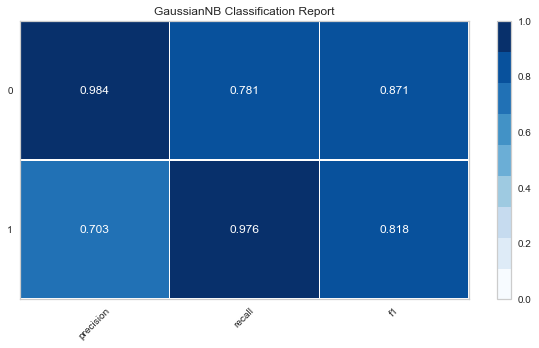

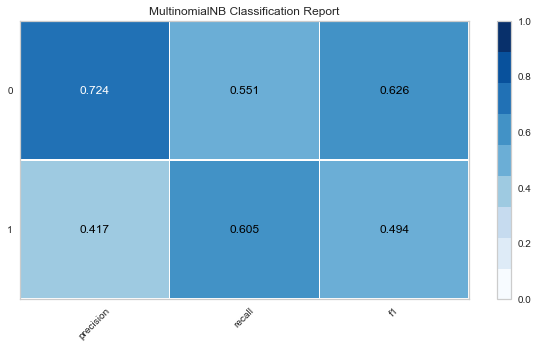

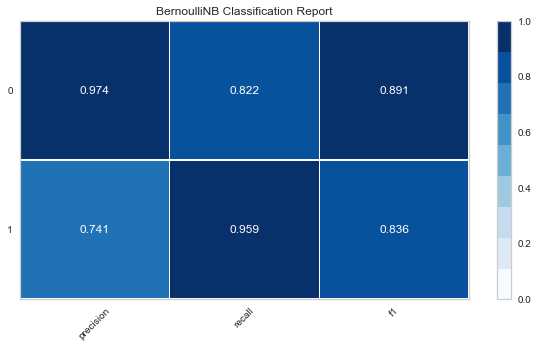

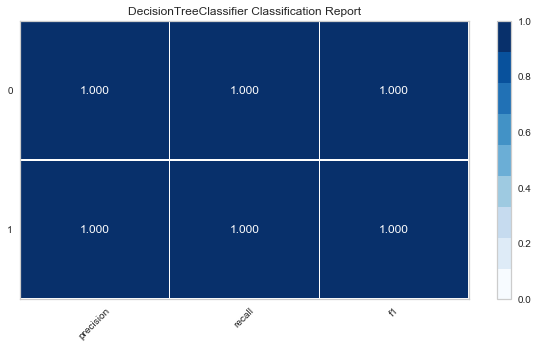

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


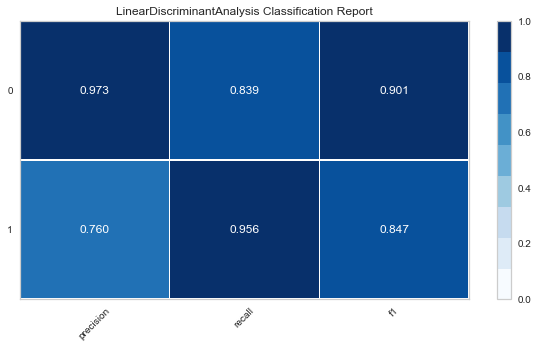

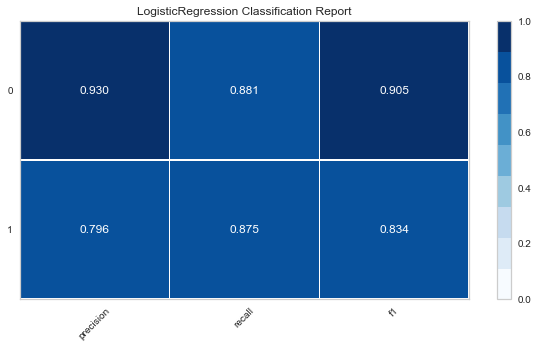

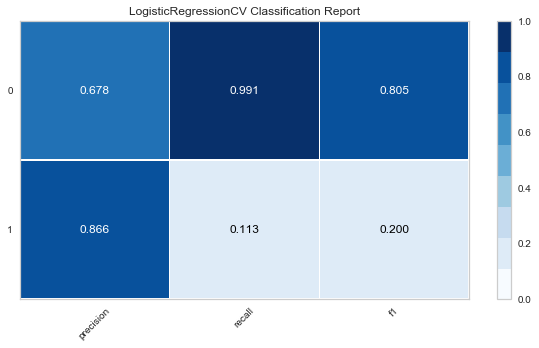

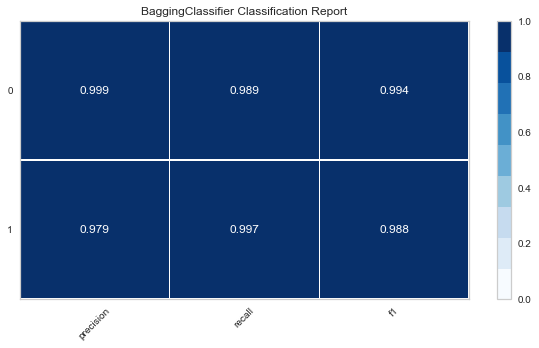

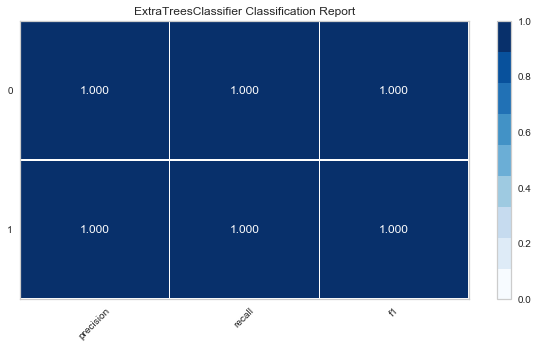

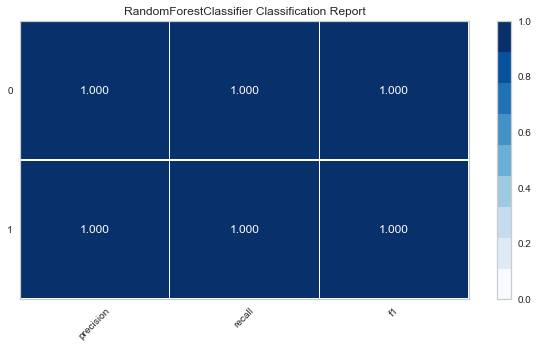

In [35]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[1,0], 
        cmap="Blues", size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

for model in models:
    visualize_model(X, y, model)